In [86]:
import os

import pandas as pd
import seaborn as sns
import snowflake.connector
from dotenv import load_dotenv
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine

load_dotenv()

engine = create_engine(
    os.getenv('DB_URL')
)

connection = engine.connect()

### Sales By Month

/Users/antran/Library/Caches/pypoetry/virtualenvs/dbt-fundamentals-Od8HDE1d-py3.9/lib/python3.9/site-packages/snowflake/sqlalchemy/snowdialect.py:206: SAWarning: Dialect snowflake:snowflake will not make use of SQL compilation caching as it does not set the 'supports_statement_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Dialect maintainers should seek to set this attribute to True after appropriate development and testing for SQLAlchemy 1.4 caching support.   Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  results = connection.execute(


<AxesSubplot:xlabel='sales_month', ylabel='sales'>

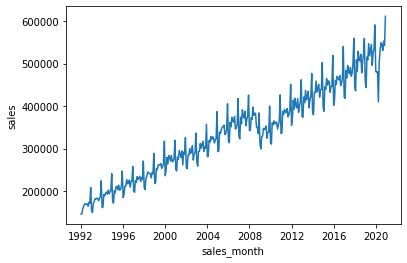

In [6]:
query = '''
select
    sales_month,
    sales

from
    ANALYTICS.DEMO.us_retail_sales

where
    kind_of_business = 'Retail and food services sales, total'
'''

df = pd.read_sql(query, connection)
sns.lineplot(data=df, x="sales_month", y="sales")

### Sales By Year

<AxesSubplot:xlabel='sales_year', ylabel='sales'>

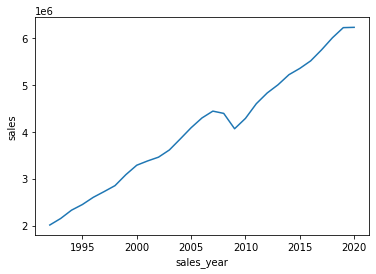

In [7]:
query = '''
select
    date_part('year', sales_month) as sales_year,
    sum(sales) as sales

from
    ANALYTICS.DEMO.us_retail_sales

where
    kind_of_business = 'Retail and food services sales, total'

group by 
    1
'''

df = pd.read_sql(query, connection)
sns.lineplot(data=df, x="sales_year", y="sales")

### Sales by business by year

<AxesSubplot:xlabel='sales_year', ylabel='sales'>

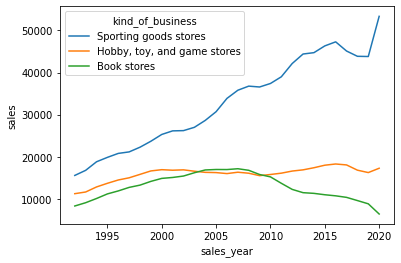

In [8]:
query = '''
select
    date_part('year', sales_month) as sales_year,
    kind_of_business,
    sum(sales) as sales

from
    ANALYTICS.DEMO.us_retail_sales

where
    kind_of_business in (
        'Hobby, toy, and game stores',
        'Book stores',
        'Sporting goods stores'
    )

group by 
    1, 2
'''

df = pd.read_sql(query, connection)
sns.lineplot(data=df, x="sales_year", y="sales", hue='kind_of_business')

### Women's vs Men's Clothing

#### By month

<AxesSubplot:xlabel='sales_month', ylabel='sales'>

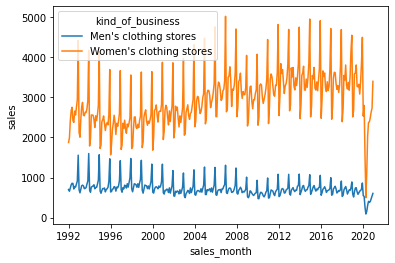

In [11]:
query = '''
select
    sales_month,
    kind_of_business,
    sales

from
    ANALYTICS.DEMO.us_retail_sales

where
    kind_of_business in (
        'Men''s clothing stores',
        'Women''s clothing stores'
    )
'''

df = pd.read_sql(query, connection)
sns.lineplot(data=df, x="sales_month", y="sales", hue='kind_of_business')

#### By year

<AxesSubplot:xlabel='sales_year', ylabel='sales'>

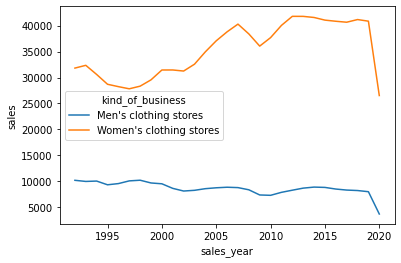

In [12]:
query = '''
select
    date_part('year', sales_month) as sales_year,
    kind_of_business,
    sum(sales) as sales

from
    ANALYTICS.DEMO.us_retail_sales

where
    kind_of_business in (
        'Men''s clothing stores',
        'Women''s clothing stores'
    )

group by 
    1, 2
'''

df = pd.read_sql(query, connection)
sns.lineplot(data=df, x="sales_year", y="sales", hue='kind_of_business')

#### Difference between Women's and Men's clothing sales

<AxesSubplot:xlabel='sales_year', ylabel='womens_minus_mens'>

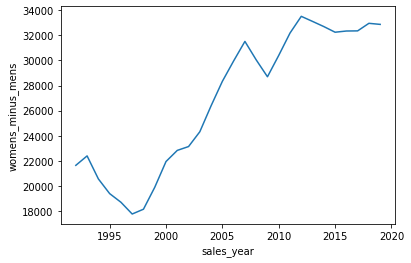

In [17]:
query = '''

with pivoted as (

    select
        date_part('year', sales_month) as sales_year,
        sum(case when kind_of_business = 'Men''s clothing stores'
                    then sales
                    end)    as mens_sales,
        sum(case when kind_of_business = 'Women''s clothing stores'
                    then sales
                    end)    as womens_sales

    from
        ANALYTICS.DEMO.us_retail_sales

    where
        kind_of_business in (
            'Men''s clothing stores',
            'Women''s clothing stores'
        )
        and sales_month <= '2019-12-01'

    group by 
        1

)

select
    sales_year,
    womens_sales - mens_sales as womens_minus_mens,
    womens_sales / mens_sales as womens_times_of_mens

from 
    pivoted

'''

df = pd.read_sql(query, connection)
sns.lineplot(data=df, x="sales_year", y="womens_minus_mens")

<AxesSubplot:xlabel='sales_year', ylabel='womens_times_of_mens'>

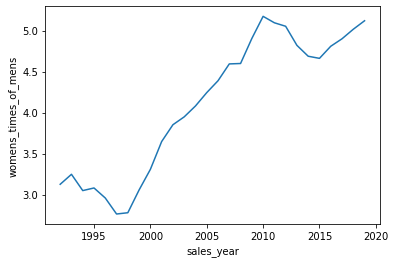

In [18]:
sns.lineplot(data=df, x="sales_year", y="womens_times_of_mens")

#### Percentage of total

<AxesSubplot:xlabel='sales_month', ylabel='pct_total'>

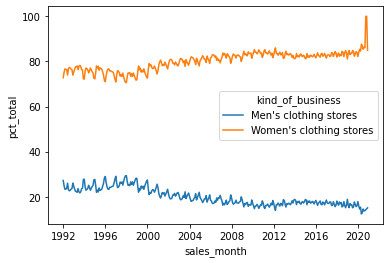

In [20]:
query = '''

select
    sales_month,
    kind_of_business,
    sales,
    sum(sales) over (partition by sales_month) as total_sales,
    sales * 100.0 / sum(sales) over (partition by sales_month) as pct_total

from 
    ANALYTICS.DEMO.us_retail_sales

where kind_of_business in (
        'Men''s clothing stores',
        'Women''s clothing stores'
    )

'''

df = pd.read_sql(query, connection)
sns.lineplot(data=df, x="sales_month", y="pct_total", hue="kind_of_business")

#### Percentage of total yearly

<AxesSubplot:xlabel='sales_month', ylabel='pct_yearly'>

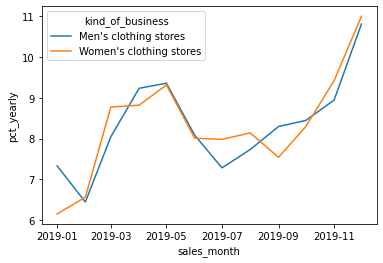

In [22]:
query = '''

select
    sales_month,
    kind_of_business,
    sum(sales) over (partition by date_part('year', sales_month), kind_of_business) as yearly_sales,
    sales * 100.0 / sum(sales) over (partition by date_part('year', sales_month), kind_of_business) as pct_yearly

from 
    ANALYTICS.DEMO.us_retail_sales

where kind_of_business in (
        'Men''s clothing stores',
        'Women''s clothing stores'
    )
    and date_part('year', sales_month) = '2019'

'''

df = pd.read_sql(query, connection)
sns.lineplot(data=df, x="sales_month", y="pct_yearly", hue="kind_of_business")

### Sales Index

<AxesSubplot:xlabel='sales_year', ylabel='pct_from_index'>

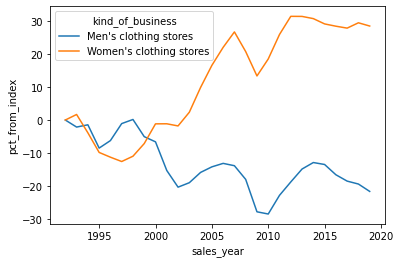

In [31]:
query = '''

with sales as (

    select
        date_part('year', sales_month) as sales_year,
        kind_of_business,
        sum(sales) as sales

    from 
        ANALYTICS.DEMO.us_retail_sales

    where kind_of_business in (
            'Men''s clothing stores',
            'Women''s clothing stores'
        )
        and sales_month <= '2019-12-01'
    
    group by 
        1, 2

)

select 
    sales_year,
    kind_of_business,
    sales,
    first_value(sales) over (order by sales_year) as index_sales,
    (sales / first_value(sales) over (partition by kind_of_business order by sales_year) - 1) * 100 as pct_from_index

from 
    sales

'''

df = pd.read_sql(query, connection)
df.head()

sns.lineplot(data=df, x="sales_year", y="pct_from_index", hue="kind_of_business")

## Rolling Time Windows

In [38]:
query = '''

with data as (

    select
        sales_month,
        kind_of_business,
        sales,
        avg(sales) over (order by sales_month
                            rows between 11 preceding and current row)
                as moving_avg,
        count(sales) over (order by sales_month
                            rows between 11 preceding and current row)
                as records_count

    from 
        ANALYTICS.DEMO.us_retail_sales

    where kind_of_business in (
                'Women''s clothing stores'
            )
)

select 
    *

from 
    data

where records_count = 12
'''

df = pd.read_sql(query, connection)
df.head()

,sales_month,kind_of_business,sales,moving_avg,records_count
0,1992-12-01,Women's clothing stores,4416,2651.250,12
1,1993-01-01,Women's clothing stores,2123,2672.083,12
2,1993-02-01,Women's clothing stores,2005,2673.250,12
3,1993-03-01,Women's clothing stores,2442,2676.500,12
4,1993-04-01,Women's clothing stores,2762,2684.583,12


<AxesSubplot:xlabel='sales_month', ylabel='moving_avg'>

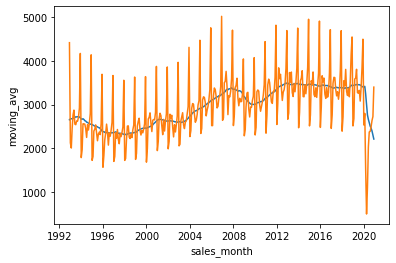

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.lineplot(data=df, x="sales_month", y="moving_avg", ax=ax)
sns.lineplot(data=df, x="sales_month", y="sales", ax=ax)

### Sparse Data

In [9]:
query = '''

with sparse_data as (
    
    select
        sales_month,
        kind_of_business,
        sales
    from
        analytics.demo.us_retail_sales
    where 1=1
        and kind_of_business in('Women''s clothing stores')
        and date_part('month', sales_month) in (1, 7)
)

select
    demo.dim_dates.date_day,
    avg(sparse_data.sales) as moving_avg,
    count(sparse_data.sales) as records_count

from
    demo.dim_dates
    inner join sparse_data on sparse_data.sales_month between dim_dates.date_day - interval '11 months'
        and dim_dates.date_day

where 1=1
    and dim_dates.date_day = dim_dates.first_day_of_month
    and dim_dates.date_day between '1993-01-01' and '2020-12-01'

group by 
    1

order by 
    1

'''

df = pd.read_sql(query, connection)
df.head()

,date_day,moving_avg,records_count
0,1993-01-01,2248.0,2
1,1993-02-01,2248.0,2
2,1993-03-01,2248.0,2
3,1993-04-01,2248.0,2
4,1993-05-01,2248.0,2


## Cumulative Values

In [85]:
query = '''

select
    sales_month,
    kind_of_business,
    sales,
    sum(sales) over (partition by date_part('year', sales_month)
                        order by sales_month
                    ) as sales_ytd
    
from
    analytics.demo.us_retail_sales

where 1 = 1
    and kind_of_business in('Women''s clothing stores')
    and sales_month between '2000-01-01' and '2020-12-01'

'''

df = pd.read_sql(query, connection)
df.head()

ProgrammingError: (snowflake.connector.errors.ProgrammingError) 390114 (08001): Authentication token has expired.  The user must authenticate again.
(Background on this error at: https://sqlalche.me/e/14/f405)

https://matplotlib.org/cheatsheets/_images/cheatsheets-1.png

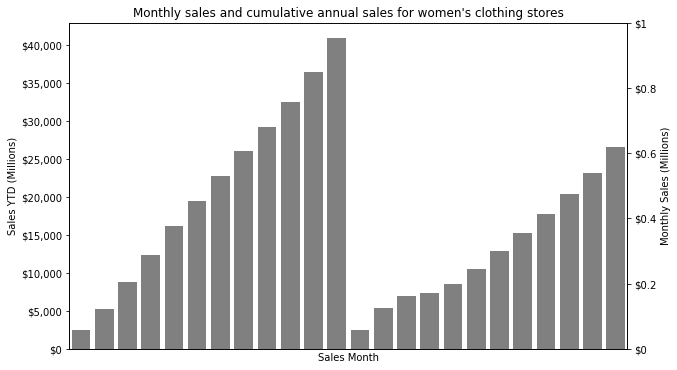

In [82]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

dollar_formatter = ticker.StrMethodFormatter('${x:,g}')

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=df, x="sales_month", y="sales_ytd", color="gray", ax=ax)
ax.set_title("Monthly sales and cumulative annual sales for women's clothing stores", fontsize=12)
ax.set_xlabel("Sales Month")
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.set_ylabel("Sales YTD (Millions)")
ax.yaxis.set_major_formatter(dollar_formatter)

ax1 = ax.twinx()
ax1.set_ylabel("Monthly Sales (Millions)")
ax1.yaxis.set_major_formatter(dollar_formatter)
ax1.xaxis.set_major_locator(ticker.NullLocator())
# sns.lineplot(data=df, x="sales_month", y="sales", ax=ax1)